### Importuri

In [1]:
from copy import deepcopy
from random import choice, choices, random
from time import sleep
import urllib

from IPython.display import clear_output

### Variabile globale

In [2]:
INFINITY = 99

DEFAULT_LEARNING_RATE = 0.1
DEFAULT_DISCOUNT_FACTOR = 0.99

TRAIN_EPISODES = 5000

EVAL_EPISODES = 1000

SLEEP_TIME = 1

MOVE_REWARD = -0.1
CHEESE_REWARD = 10.0
LOSE_REWARD = -20.0

ACTIONS = ["UP", "RIGHT", "DOWN", "LEFT", "STAY"]

ACTION_EFFECTS = {
    "UP": (-1,0),
    "RIGHT": (0,1),
    "DOWN": (1,0),
    "LEFT": (0,-1),
    "STAY": (0,0)
}

### Declararea claselor pentru pozitie si pentru stare

In [3]:
class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return str(self.x) + ' ' + str(self.y)
        
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __sub__(self, other):
        return abs(self.x - other.x), abs(self.y - other.y)
    
    def __hash__(self):
        return hash((self.x, self.y))

class State:
    def __init__(self, name, A, mouse, cat, maze):
        self.name = name
        self.A = A
        self.mouse = mouse
        self.cat = cat
        self.maze = maze
        
    def __str__(self):
        maze = deepcopy(self.maze)
        maze[self.mouse.x] = ''.join([
            'M' if i == self.mouse.y else maze[self.mouse.x][i]
            for i in range(len(maze[0]))
        ])
        maze[self.cat.x] = ''.join([
            'C' if i == self.cat.y else maze[self.cat.x][i]
            for i in range(len(maze[0]))
        ])
        
        return '\n'.join(maze)
        
    def __eq__(self, other):
        return self.mouse == other.mouse and self.cat == other.cat and self.maze == other.maze
    
    def __hash__(self):
        return hash((self.mouse, self.cat, tuple(self.maze)))
    
    def is_won(self):
        return all(['o' not in line for line in self.maze])
    
    def is_lost(self, reward):
        return reward < -20.0 or self.mouse == self.cat
    
    def is_final(self, reward):
        return self.is_won() or self.is_lost(reward)
    
    def is_valid_cell(self, position):
        return position.x >= 0 and position.x < len(self.maze) and \
            position.y >= 0 and position.y < len(self.maze[0]) and \
            self.maze[position.x][position.y] != "*"
    
    def next_position(self, pos, action):
        return Position(
            pos.x + ACTION_EFFECTS[action][0],
            pos.y + ACTION_EFFECTS[action][1]
        )
    
    def get_legal_actions(self, agent='mouse'):
        if agent == 'mouse':
            pos = self. mouse
        elif agent == 'cat':
            pos = self.cat
    
        return [action for action in ACTIONS if self.is_valid_cell(self.next_position(pos, action))]
    
    def apply_action(self, action):
        assert(action in ACTIONS)
        
        reward = 0
        message = "Mouse moved %s." % action
        
        new_mouse = self.next_position(self. mouse, action)
        
        if not self.is_valid_cell(new_mouse):
            message = f"{message} Not a valid cell there."
        else:
            self.mouse = new_mouse
            
        dy, dx = self.mouse - self.cat
        cat_action = None
        
        if dx + dy <= self.A:
            m = INFINITY
            a = None

            for action in self.get_legal_actions('cat'):
                new_cat = self.next_position(self.cat, action)
                dy, dx = new_mouse - new_cat
                
                if dx + dy < m:
                    m = dx + dy
                    a = action
                    
            cat_action = a
        else:
            cat_action = choice(self.get_legal_actions('cat'))
            
        message = f"{message} Cat moved %s." % cat_action
        self.cat = self.next_position(self.cat, cat_action)
            
        if self.mouse == self.cat:
            message = f"{message} The cat ate the mouse."
            reward += LOSE_REWARD
            
        if self.maze[self.mouse.x][self.mouse.y] == 'o':
            message = f"{message} The mouse ate a slice of cheese."
            self.maze[self.mouse.x] = ''.join([
                ' ' if i == self.mouse.y else self.maze[self.mouse.x][i]
                for i in range(len(self.maze[0]))
            ])
            reward += CHEESE_REWARD
            
        reward += MOVE_REWARD
        
        return reward, message

### Citirea starilor initiale din fisier

   Prima harta este una destul de simplista, soarecele putand doar sa fuga de pisica si va culege intr-un final bucatile de branza.
   
   Cea de-a doua harta este una deschisa.
   
   In cea de-a treia harta bucatile de branza sunt in niste fundaturi si soarecele trebuie sa fie atent sa nu fie prins de pisica in timp ce incearca sa le culeaga.

In [4]:
def read_state(name):
    with open('maps/' + name, 'r') as f:
        A = int(f.readline().replace('\n', ''))
        mouse = Position(*[int(n) for n in f.readline().replace('\n', '').split(' ')])
        cat = Position(*[int(n) for n in f.readline().replace('\n', '').split(' ')])
        
        maze = []
        
        for line in f:
            maze.append(line.replace('\n', ''))
            
    return State(name, A, mouse, cat, maze)

state1 = read_state('state1')
state2 = read_state('state2')
state3 = read_state('state3')

### Strategiile de alegere a urmatoarei actiuni

In [5]:
def max_first(Q, state):
    max_val = -INFINITY
    a = None
    
    for action in state.get_legal_actions():
        value = 0
        
        if (state, action) in Q:
            value = Q[(state, action)]
            
        if value > max_val:
            max_val = value
            a = action
            
    return a

def random(Q, state):
    return choice(state.get_legal_actions())

def explore(Q, state):
    unexplored_actions = [action for action in state.get_legal_actions() if (state, action) not in Q]

    if unexplored_actions:
        return choice(unexplored_actions)
    
    return max_first(Q, state)
    
def weighted_explore(Q, state):
    legal_actions = state.get_legal_actions()
    
    values = [Q[(state, action)] if (state, action) in Q else 0 for action in legal_actions]
    
    # if all values are equal, choice at random
    if all([value == values[0] for value in values]):
        return choice(legal_actions)
    
    return choices(legal_actions, [(value-min(values))/(max(values)-min(values)) for value in values])[0]

###  Algoritmi Q Learning si SARSA

In [6]:
def q_learning(get_next_action, initial_state, learning_rate, discount_factor):
    Q = {}
    train_scores = []
    Q_means = []
    
    for train_ep in range(1, TRAIN_EPISODES+1):
        print(
            f"Q Learning Train Episode {train_ep} / {TRAIN_EPISODES}\
            state: {initial_state.name}    strategy: {get_next_action.__name__}\
            learning rate: {learning_rate}    discount factor: {discount_factor}"
        )
        
        score = 0
        state = deepcopy(initial_state)
        
        while not state.is_final(score):
            action = get_next_action(Q, state)
            last_state = deepcopy(state)
            
            if (last_state, action) not in Q:
                Q[(last_state, action)] = 0
            
            reward, _ = state.apply_action(action)
            score += reward
            
            max_val = -INFINITY
            for a in state.get_legal_actions():
                if (state, a) in Q:
                    if max_val < Q[(state, a)]:
                        max_val = Q[(state, a)]
                else:
                    if max_val < 0:
                        max_val = 0
                        
            Q[(last_state, action)] += learning_rate * (reward + 
                discount_factor * max_val - Q[(last_state, action)]
            )
        
        train_scores.append(score)
        Q_means.append(sum(Q.values())/len(Q))
        
        clear_output(wait=True)
    
    return Q, train_scores, Q_means

def sarsa(get_next_action, initial_state, learning_rate, discount_factor):
    Q = {}
    train_scores = []
    Q_means = []
    
    for train_ep in range(1, TRAIN_EPISODES+1):
        print(
            f"Sarsa Train Episode {train_ep} / {TRAIN_EPISODES}\
            state: {initial_state.name}    strategy: {get_next_action.__name__}\
            learning rate: {learning_rate}    discount factor: {discount_factor}"
        )
        
        score = 0
        state = deepcopy(initial_state)
        
        while not state.is_final(score):
            action = get_next_action(Q, state)
            last_state = deepcopy(state)
            
            reward, _ = state.apply_action(action)
            score += reward
    
            next_action = get_next_action(Q, state)
    
            if (last_state, action) not in Q:
                Q[(last_state, action)] = 0
    
            if (state, next_action) not in Q:
                Q[(state, next_action)] = 0
    
            Q[(last_state, action)] += learning_rate * (reward + 
                discount_factor * Q[(state, next_action)] - Q[(last_state, action)]
            )
        
        train_scores.append(score)
        Q_means.append(sum(Q.values())/len(Q))
        
        clear_output(wait=True)
    
    return Q, train_scores, Q_means

### Functia de evaluare si de plot

In [7]:
def eval(Q, initial_state, strategy_name):
    games_won = 0
    
    for eval_ep in range(1, EVAL_EPISODES+1):
        print(
            f"Eval Episode {eval_ep} / {EVAL_EPISODES}\
            state: {initial_state.name}    strategy: {strategy_name}"
        )
        
        state = deepcopy(initial_state)
        score = 0
        
        while not state.is_final(score):
            action = max_first(Q, state)
            reward, _ = state.apply_action(action)
            score += reward
            
        if state.is_won():
            games_won += 1
            
        clear_output(wait=True)

    return games_won/EVAL_EPISODES

def plot(xlabel, ylabel, *values):
    colors = ['red', 'green', 'blue']
    
    from matplotlib import pyplot as plt
    import numpy as np
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    for i in range(len(values)):
        plt.plot(
            np.linspace(1, len(values[i]), len(values[i])),
            np.convolve(values[i], [0.2,0.2,0.2,0.2,0.2], 'same'),
            linewidth = 1.0, color = colors[i % len(colors)]
        )
    plt.show()

###  Evolutia scorului în functie de numarul episodului de antrenament
Pentru primele doua harti max_first este cel mai bun, deaorece cea mai eficienta strategie este se duca direct la branza.

Pentru a treia harta, insa, daca se duce direct la branza poate fi prins de pisica, asa ca o strategie bazata pe explorare este mai potrivita.

In [8]:
states = [state1, state2, state3]
stategies = [max_first, random, explore, weighted_explore]

names = [state.name + ' ' + strategy.__name__ for state in states for strategy in stategies]
train_scores = {}
Q_means = {}
win_percentages = {}

for state in states:
    for strategy in stategies:
        Q, train_score, Q_mean = q_learning(strategy, state, DEFAULT_LEARNING_RATE, DEFAULT_DISCOUNT_FACTOR)
        win_percent = eval(Q, state, strategy.__name__)
        
        name = state.name + ' ' + strategy.__name__
        train_scores[name] = train_score
        Q_means[name] = Q_mean
        win_percentages[name] = win_percent

state1 max_first 0.997


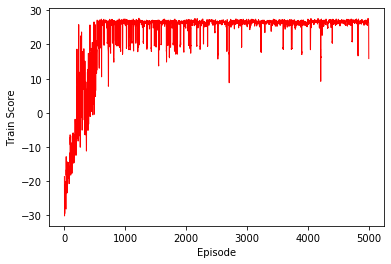

state1 random 0.031


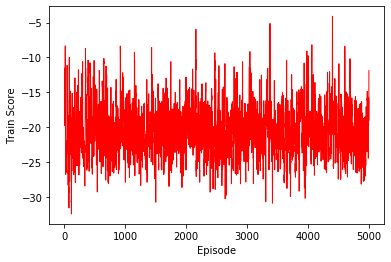

state1 explore 0.992


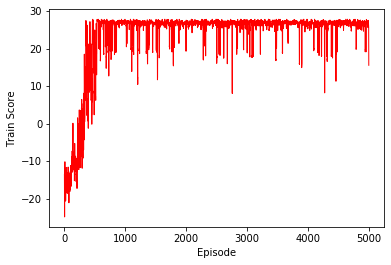

state1 weighted_explore 0.996


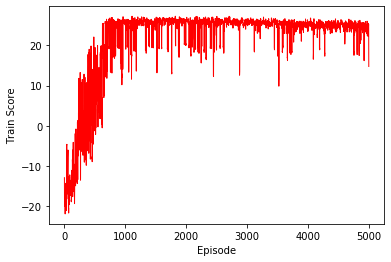

state2 max_first 0.963


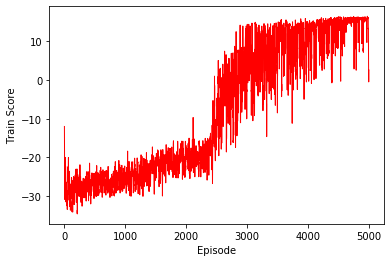

state2 random 0.0


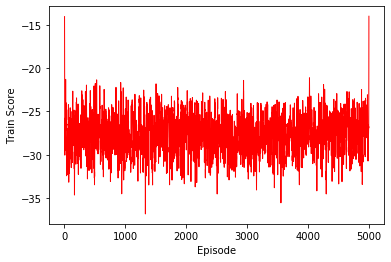

state2 explore 0.954


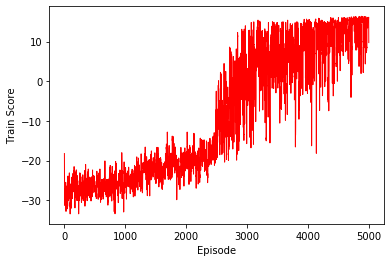

state2 weighted_explore 0.865


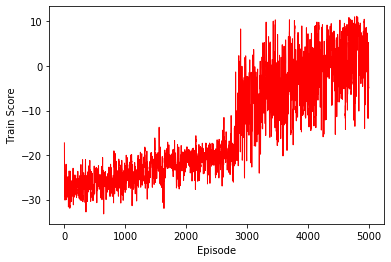

state3 max_first 0.962


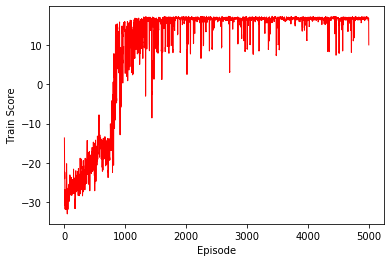

state3 random 0.0


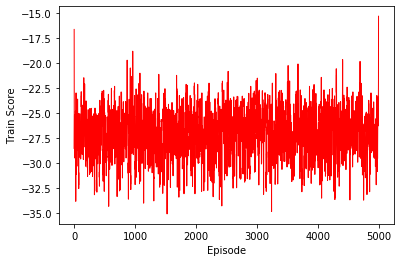

state3 explore 0.974


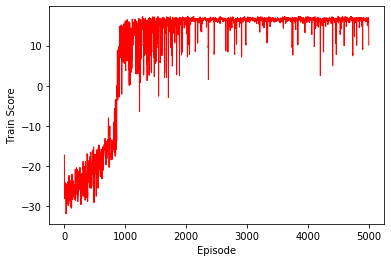

state3 weighted_explore 0.987


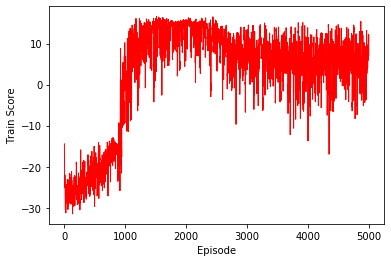

In [9]:
for name in names:
    print(name, win_percentages[name])
    plot('Episode', 'Train Score', train_scores[name])

### Procentul de jocuri castigate în functie factorul de invatare si cel de discount
Dupa cum se poate vedea pe grafice, factorul de invatare nu influenteaza atat de mult, atata timp cat nu este foarte mic.

Factorul de discount, in schimb, trebuie sa aiba o valuare mai mare pentru obtinerea rezultatelor mai bune.

In [10]:
TRAIN_EPISODES = 1000
EVAL_EPISODES = 500

learning_rates = [learning_rate * 0.01 for learning_rate in range(1, 100)]
discount_factors = [discount_factor * 0.01 for discount_factor in range(1, 100)]

learning_rate_scores = {name: [] for name in names}
discount_factor_scores = {name: [] for name in names}

for strategy in stategies:
    for learning_rate in learning_rates:
        Q, _, _ = q_learning(strategy, state1, learning_rate, DEFAULT_DISCOUNT_FACTOR)
        win_percent = eval(Q, state1, strategy.__name__)

        name = state1.name + ' ' + strategy.__name__

        learning_rate_scores[name].append(win_percent)
                               
for strategy in stategies:
    for discount_factor in discount_factors:
        Q, _, _ = q_learning(strategy, state1, DEFAULT_LEARNING_RATE, discount_factor)
        win_percent = eval(Q, state1, strategy.__name__)

        name = state1.name + ' ' + strategy.__name__

        discount_factor_scores[name].append(win_percent)

state1 max_first


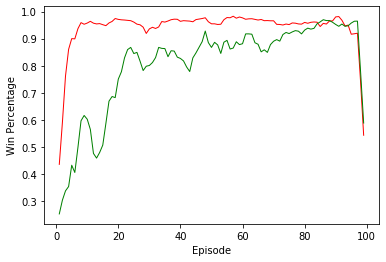

state1 random


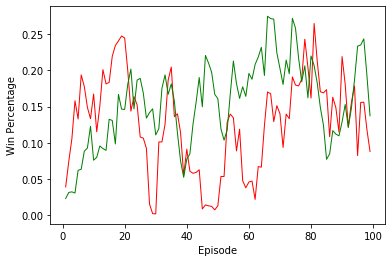

state1 explore


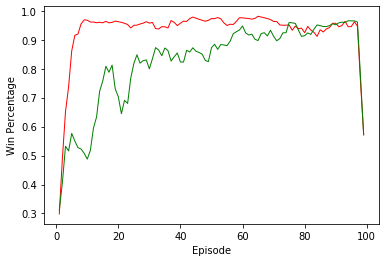

state1 weighted_explore


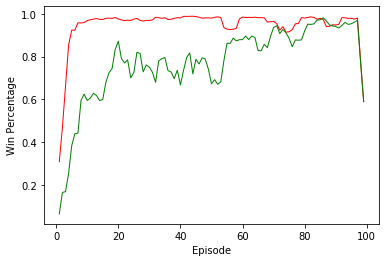

In [11]:
for name in names:
    if 'state1' in name:
        print(name)
        plot('Value', 'Win Percentage', learning_rate_scores[name], discount_factor_scores[name])

### Analiza tabelelor de utilitati
Graficele arata valoare medie a tabelelor Q. Se poate observa ca este un fel de parabola. Incepand de la 0, valorile incep sa scada pana se ajunge la o bucata de branza, apoi valorile incep sa creasca, deoarece toate starile duc spre o solutie(nu avem doar reward negativ).

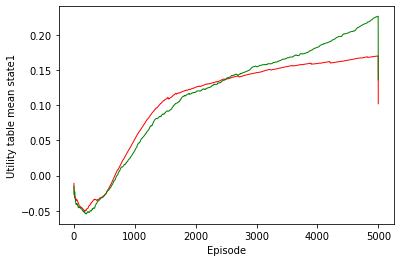

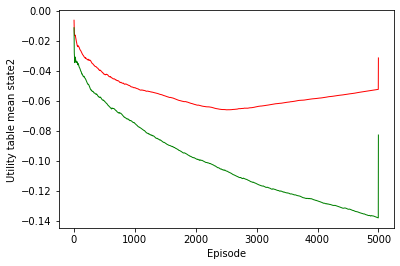

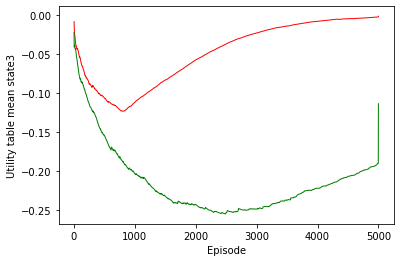

In [12]:
for state in states:
    max_first_Q_means = state.name + ' max_first'
    random_Q_means = state.name + ' random'
    
    plot('Episode', 'Utility table mean ' + state.name, Q_means[max_first_Q_means], Q_means[random_Q_means])

### Q Learning vs Sarsa
O diferenta notabila este la strategia de explorare, unde SARSA converge mai greu pe primele doua harti.

Pe a treia harta, care contine niste pericole, SARSA pare sa se descurce umpic mai bine.

In [13]:
TRAIN_EPISODES = 5000
EVAL_EPISODES = 1000

states = [state1, state2, state3]
stategies = [max_first, random, explore, weighted_explore]

names = [state.name + ' ' + strategy.__name__ for state in states for strategy in stategies]

q_train_scores = {}
q_win_percentages = {}
sarsa_train_scores = {}
sarsa_win_percentages = {}

for state in states:
    for strategy in stategies:
        q_Q, q_train_score, _ = q_learning(strategy, state, DEFAULT_LEARNING_RATE, DEFAULT_DISCOUNT_FACTOR)
        q_win_percent = eval(q_Q, state, strategy.__name__)
        sarsa_Q, sarsa_train_score, _ = sarsa(strategy, state, DEFAULT_LEARNING_RATE, DEFAULT_DISCOUNT_FACTOR)
        sarsa_win_percent = eval(sarsa_Q, state, strategy.__name__)
        
        name = state.name + ' ' + strategy.__name__
    
        q_train_scores[name] = q_train_score
        q_win_percentages[name] = q_win_percent
        sarsa_train_scores[name] = sarsa_train_score
        sarsa_win_percentages[name] = sarsa_win_percent

state1 max_first q learning win percentage: 0.998 sarsa win percentage: 0.994


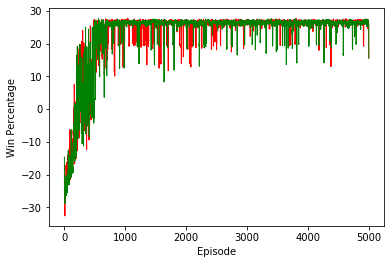

state1 random q learning win percentage: 0.012 sarsa win percentage: 0.119


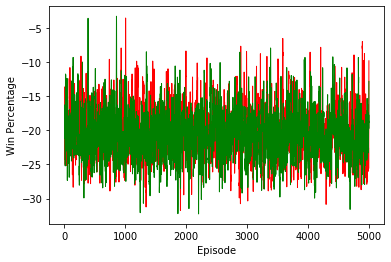

state1 explore q learning win percentage: 0.997 sarsa win percentage: 0.618


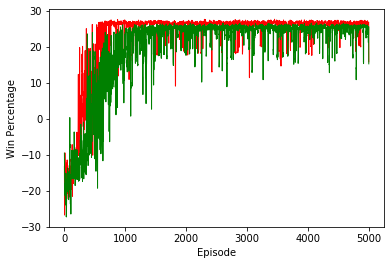

state1 weighted_explore q learning win percentage: 0.987 sarsa win percentage: 0.996


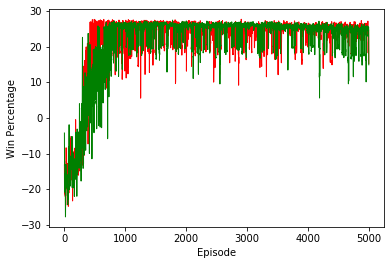

state2 max_first q learning win percentage: 0.968 sarsa win percentage: 0.977


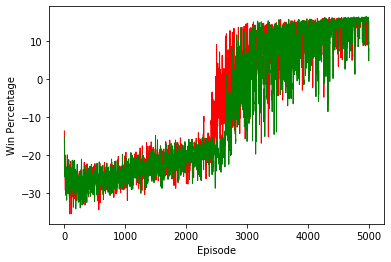

state2 random q learning win percentage: 0.0 sarsa win percentage: 0.0


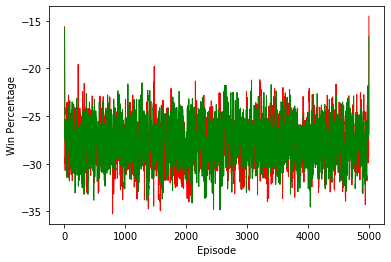

state2 explore q learning win percentage: 0.601 sarsa win percentage: 0.095


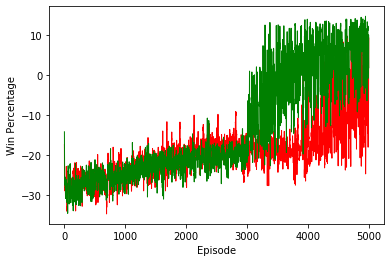

state2 weighted_explore q learning win percentage: 0.891 sarsa win percentage: 0.005


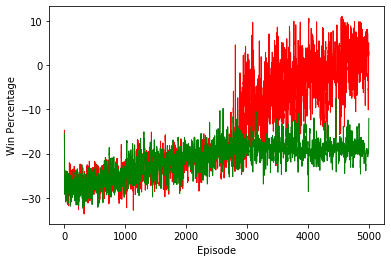

state3 max_first q learning win percentage: 0.99 sarsa win percentage: 1.0


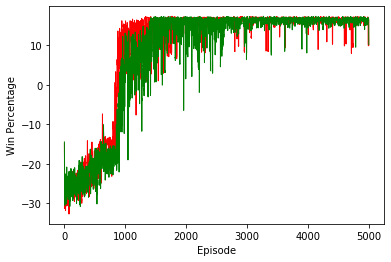

state3 random q learning win percentage: 0.0 sarsa win percentage: 0.0


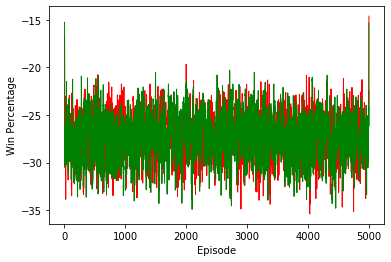

state3 explore q learning win percentage: 0.95 sarsa win percentage: 0.947


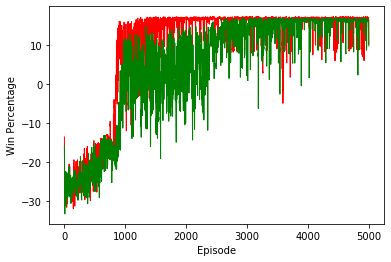

state3 weighted_explore q learning win percentage: 0.974 sarsa win percentage: 0.976


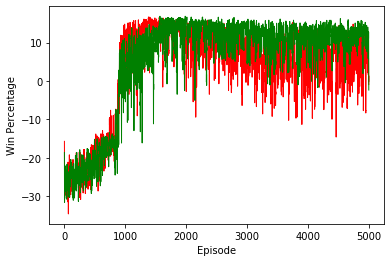

In [14]:
for name in names:
    print(name,
        'q learning win percentage:', q_win_percentages[name],
        'sarsa win percentage:', sarsa_win_percentages[name]
    )
    plot('Episode', 'Win Percentage', q_train_scores[name], sarsa_train_scores[name])

### Try it yourself

In [ ]:
def run(algorithm, strategy, initial_state, sleep_time):
    state = deepcopy(initial_state)
    
    Q, _, _ = algorithm(strategy, initial_state, DEFAULT_LEARNING_RATE, DEFAULT_DISCOUNT_FACTOR)
    score = 0
    
    while not state.is_final(score):
        action = max_first(Q, state)
        reward, msg = state.apply_action(action)
        score += reward
        print(msg); print(state); sleep(sleep_time)
        clear_output(wait=True)
        
run(q_learning, max_first, state1, 0.5)